In [1]:
import pandas as pd
import numpy as np
import tcrdist
import tcrdist.repertoire

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import itertools
import os
import pathlib
import subprocess
import io

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
from IPython.display import display, HTML
display(HTML("""
<style>
.lm-Widget {overflow-x: scroll !important;}
</style>
"""))

In [4]:
pd.options.display.max_columns = 200

In [5]:
hla_noncov = pd.read_csv('../analysis/mira_postgliph_hla_noncov_curated.csv')
hla_cov = pd.read_csv('../analysis/mira_postgliph_hla_cov_curated.csv', index_col=0)

In [6]:
all_hlas = pd.concat([hla_noncov, hla_cov])

In [7]:
all_hlas.hla_b = all_hlas.hla_b.replace({'B*07:01': 'B*07:02'})

In [8]:
all_hlas.study_id.nunique()

31

In [9]:
mira = pd.read_csv('../analysis/mira_postgliph_2.csv', index_col=0)

In [10]:
mira = mira.reset_index()

# Explore GLIPH duplicates pre-dedup

In [11]:
df = pd.read_csv('../analysis/post_gliph_filter_nik.csv', index_col=0)

In [12]:
df.shape

(2338, 10)

In [ ]:
df

In [14]:
df.TcRb.nunique()

1196

In [15]:
tcr_df = df.groupby('TcRb').agg({
    'TcRb': 'size',
    'pattern': 'nunique',
    'study_id': 'nunique',
}).rename(columns={'TcRb': 'n_tcrs', 'pattern': 'n_patterns', 'study_id': 'n_patients'})

In [16]:
tcr_df.value_counts().reset_index(name='cnt').sort_values(['n_patterns', 'cnt'], ascending=[True, False])

,n_tcrs,n_patterns,n_patients,cnt
0,1,1,1,758
1,2,1,1,134
3,3,1,1,33
4,2,1,2,29
6,4,1,1,16
7,3,1,2,11
9,5,1,1,9
11,5,1,2,6
12,4,1,2,5
16,6,1,1,4


# IEDB HLA binding affinity

In [17]:
IEDB_QUERY = pathlib.Path('02_iedb_query')

In [18]:
os.makedirs(IEDB_QUERY, exist_ok=True)

In [19]:
hla_info = all_hlas.groupby('study_id').agg({
    'hla_a': tuple,
    'hla_b': tuple
}).reset_index()

In [20]:
mira_hla = mira.merge(hla_info, on='study_id', how='left')

These have missing HLA information

In [ ]:
mira_hla.loc[mira_hla.hla_a.isna()]

In [22]:
all_epitopes = pd.Series(pd.Series(itertools.chain(*mira_hla.Amino_Acids.str.split(','))).unique())

In [23]:
def generate_fastq(epitopes):
    epitope_fastq = ''
    for epitope in epitopes:
        epitope_fastq += f'> {epitope}\n{epitope}\n\n'
    return epitope_fastq

In [24]:
epitope_fastqs = all_epitopes.groupby(all_epitopes.str.len()).apply(generate_fastq)

In [25]:
for length, fastq in epitope_fastqs.items():
    with open(IEDB_QUERY / f'epitopes_{length}.fasta', 'w') as f:
        f.write(fastq)

In [26]:
IEDB_TOOL = '/projects/p31980/MoralesNebreda_Lab/tools/mhc_i/src/predict_binding.py'

In [27]:
unique_hlas = 'HLA-' + pd.Series(pd.concat([all_hlas.hla_a, all_hlas.hla_b]).unique())

In [28]:
%%time
if (IEDB_QUERY / 'results.csv').exists():
    iedb_results = pd.read_csv(IEDB_QUERY / 'results.csv', index_col=0)
else:
    iedb_results = []
    for length in epitope_fastqs.index:
        command = [
            'python',
            IEDB_TOOL,
            'netmhcpan_el',
            ','.join(unique_hlas),
            ','.join([str(length)] * unique_hlas.size),
            str(IEDB_QUERY / f'epitopes_{length}.fasta')
        ]
        result = subprocess.run(command, capture_output=True)
        iedb_results.append(pd.read_table(io.StringIO(result.stdout.decode())))
    iedb_results = pd.concat(iedb_results)
    iedb_results.reset_index(drop=True, inplace=True)
    iedb_results.to_csv(IEDB_QUERY / 'results.csv')

CPU times: user 16.7 ms, sys: 5.65 ms, total: 22.4 ms
Wall time: 48.4 ms


In [29]:
iedb_results.set_index(['allele', 'peptide'], inplace=True)

In [30]:
iedb_results

seq_num  start  end  length       core  \
allele      peptide                                                  
HLA-B*42:01 QPYRVVVL              3      1    8       8  QPY-RVVVL   
            APKEIIFL              1      1    8       8  APKEIIF-L   
            LPQGFSAL              6      1    8       8  LPQ-GFSAL   
HLA-B*08:01 QPYRVVVL              3      1    8       8  QPY-RVVVL   
HLA-B*42:01 APHGVVFL              7      1    8       8  APH-GVVFL   
...                             ...    ...  ...     ...        ...   
HLA-B*39:01 STDTGVEHVTFFIY        1      1   14      14  SEHVTFFIY   
HLA-B*40:01 VLPPLLTDEMIAQY        3      1   14      14  VTDEMIAQY   
HLA-B*39:01 VLPPLLTDEMIAQY        3      1   14      14  VLDEMIAQY   
HLA-B*81:01 STDTGVEHVTFFIY        1      1   14      14  STDTGVEHY   
HLA-B*48:01 STDTGVEHVTFFIY        1      1   14      14  SEHVTFFIY   

                                     icore     score   rank  
allele      peptide                                          
HLA-B*42:01 QPYRVVVL              QPYRVVVL  0.917296   0.05  
            APKEIIFL              APKEIIFL  0.849793   0.08  
            LPQGFSAL              LPQGFSAL  0.827093   0.09  
HLA-B*08:01 QPYRVVVL              QPYRVVVL  0.762711   0.05  
HLA-B*42:01 APHGVVFL              APHGVVFL  0.757724   0.14  
...                                    ...       ...    ...  
HLA-B*39:01 STDTGVEHVTFFIY  STDTGVEHVTFFIY  0.000005  66.00  
HLA-B*40:01 VLPPLLTDEMIAQY  VLPPLLTDEMIAQY  0.000004  56.00  
HLA-B*39:01 VLPPLLTDEMIAQY  VLPPLLTDEMIAQY  0.000004  70.00  
HLA-B*81:01 STDTGVEHVTFFIY  STDTGVEHVTFFIY  0.000004  66.00  
HLA-B*48:01 STDTGVEHVTFFIY  STDTGVEHVTFFIY  0.000004  59.00  

[9310 rows x 8 columns]

## TODO

1. for each row in mira
2. for each epitope in the row
3. find best (smallest) rank score for all allele
4. report best rank score among epitopes for row

In [31]:
iedb_mira_index = mira_hla.Amino_Acids.apply(
    lambda x: pd.Series(x.split(','))
).reset_index(names='id').melt(
    id_vars='id',
    value_name='epitope'
).dropna()

In [32]:
iedb_mira_index = iedb_mira_index.merge(mira_hla[['hla_a', 'hla_b']], left_on='id', right_index=True)

In [33]:
iedb_mira_index = iedb_mira_index.dropna()

In [34]:
iedb_mira_index = iedb_mira_index.explode('hla_a').explode('hla_b').melt(
    id_vars=['id', 'epitope'],
    value_vars=['hla_a', 'hla_b'],
    value_name='hla'
)

In [35]:
iedb_mira_index = iedb_mira_index.groupby('id').apply(
    lambda x: x.drop_duplicates(),
    include_groups=False
).reset_index(names=['id', '_'])

In [36]:
iedb_mira_index.hla = 'HLA-' + iedb_mira_index.hla

In [37]:
iedb_mira_index.shape

(11314, 5)

In [38]:
iedb_mira_index['binding_rank'] = iedb_results['rank'].loc[
    iedb_mira_index.apply(lambda r: (r.hla, r.epitope), axis=1).values
].values

In [39]:
iedb_affinity = iedb_mira_index.sort_values(['id', 'binding_rank']).groupby('id').head(1).set_index('id')

In [40]:
idx = mira_hla.index.isin(iedb_affinity.index)
mira_hla.loc[idx, 'binding_rank'] = iedb_affinity.binding_rank[mira_hla.index[idx]]

In [41]:
mira_hla.shape

(825, 56)

In [42]:
mira_hla.binding_rank.lt(1).sum()

574

<Axes: >

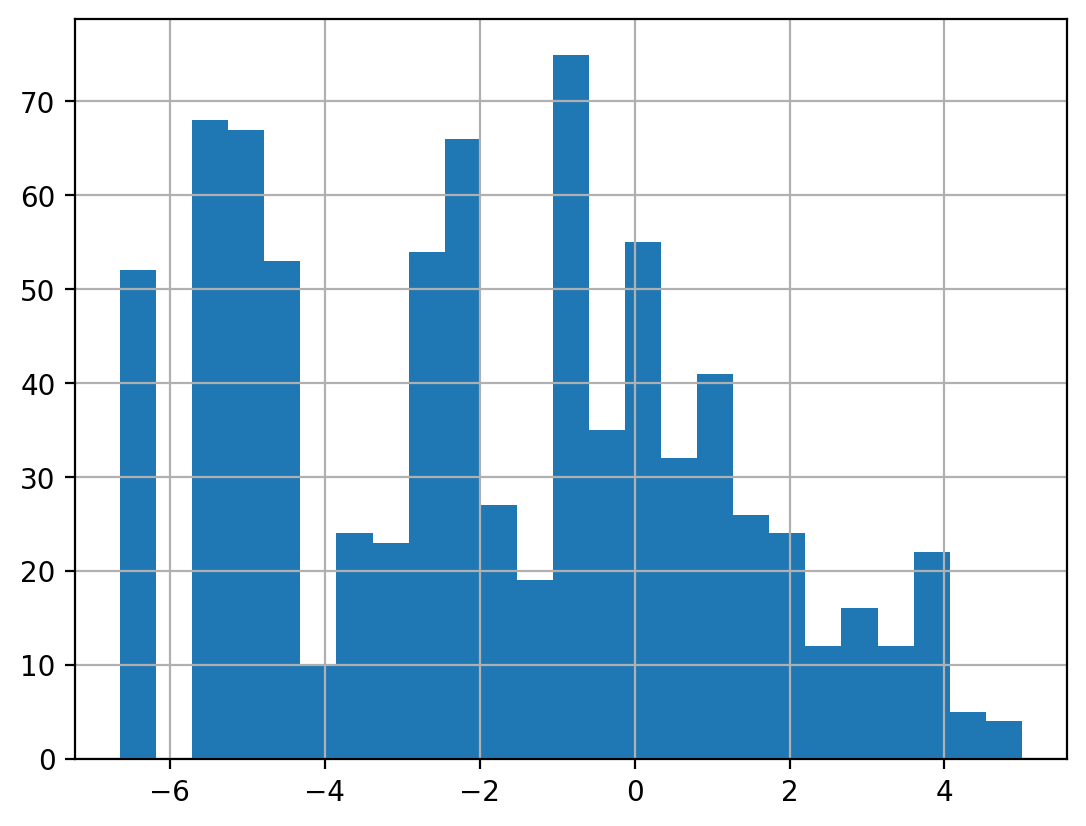

In [43]:
np.log2(mira_hla.binding_rank).hist(bins=25)

<Axes: ylabel='Frequency'>

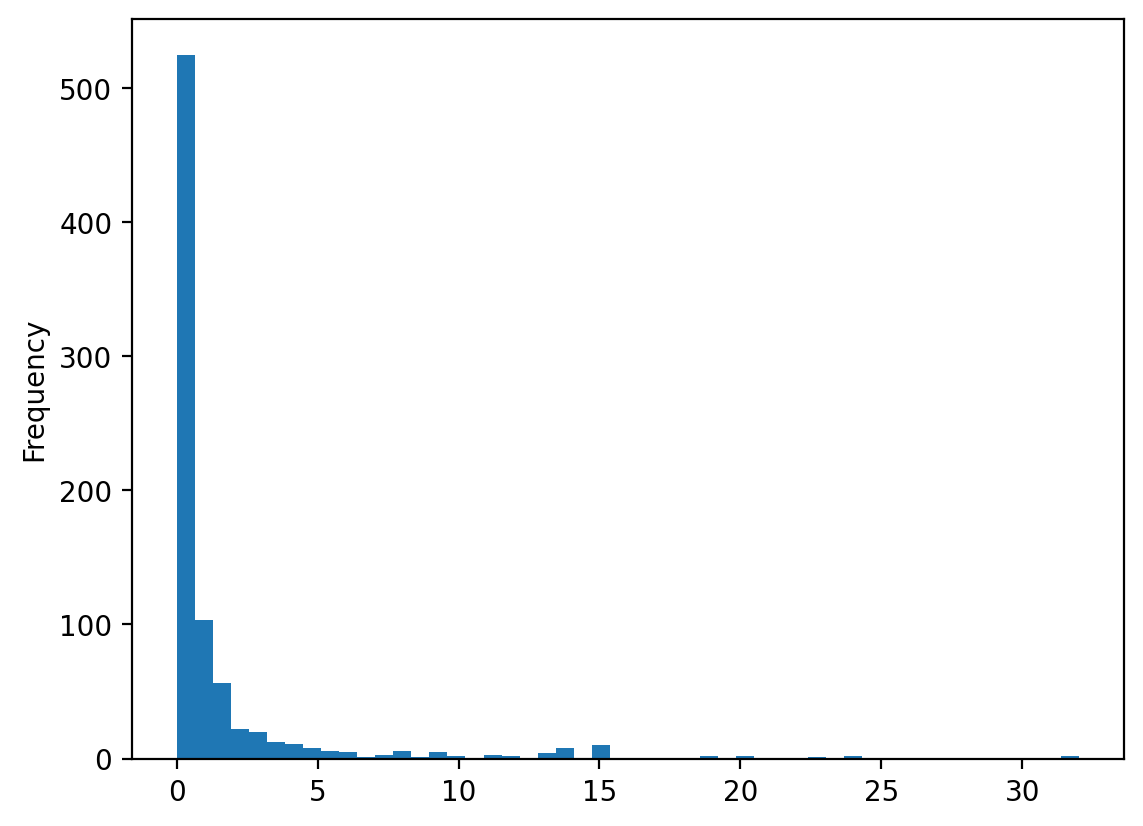

In [44]:
mira_hla.binding_rank.plot.hist(bins=50)

In [45]:
mira_hla.binding_rank.ge(5).sum()

70

In [ ]:
mira_hla

## JOIN Pgen

In [47]:
pgens = pd.read_csv('../analysis/post_gliph_filter_nik_with_pgen.csv', index_col=0)

In [48]:
pgens[['cdr3_b_aa', 'pgen_log10']].drop_duplicates()

,cdr3_b_aa,pgen_log10
0,CAIGTGDSNQPQHF,-7.939531
4,CAISTGDSNQPQHF,-8.174166
9,CASGTGDSNQPQHF,-7.053136
11,CASSTGDSNQPQHF,-6.332912
13,CASWTGDSNQPQHF,-7.736775
...,...,...
1932,CASSYSWGANTEAFF,-8.282960
1933,CASSYSWGIQPQHF,-8.728777
1934,CASSYSWGNQPQHF,-7.466566
1935,CASSYSWGPGTGELFF,-9.270532


In [49]:
pgens.cdr3_b_aa.nunique()

1196

In [50]:
tcr_to_pgen = pgens[['cdr3_b_aa', 'pgen_log10']].drop_duplicates().set_index('cdr3_b_aa').pgen_log10

In [51]:
mira_hla['pgen_log10'] = tcr_to_pgen[mira_hla.TCR].values

## SAVE

In [52]:
mira_hla.to_csv(
    '../analysis/mira_iedb_pgen_all.csv'
)

In [53]:
cross_epitopes = pd.read_csv('../analysis/mira_postgliph_epitopes_df_cd8.csv', index_col=0)

In [54]:
non_cov_epitopes_ge_3 = cross_epitopes.Epitope[cross_epitopes.n_noncovid_pts.ge(3)]

In [55]:
mira_hla.loc[mira_hla.Epitope.isin(non_cov_epitopes_ge_3)].to_csv(
    '../analysis/mira_iedb_pgen_non_cov_ge_3.csv'
)